In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbconvert
import pandoc

from pandas_datareader import fred
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import VECM

from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [76]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def adf_test_summary(ser):
    # ADF H0: there is a unit root

    specs = {'constant': 'c', 'constant trend': 'ct', 'constant ltend, qtrend': 'ctt', 'none': 'n'}
    results = {}

    for pretty, spec in specs.items():
        adf, pval, ulag, nobs, cval, icb = adfuller(ser, regression=spec)
        keys = ['adf-stat', 'p-value', '#lags', '#obs', *cval.keys(), 'inf crit']
        res = [adf, pval, ulag, nobs, *cval.values(), icb]
        results[pretty] = dict(zip(keys, res))

    if ser.name is not None:
        title = ser.name.upper()
    else:
        title = ''

    print('-' * 77)
    print(f'ADF Test {title}: H0 there is a unit root')
    print('-' * 77)
    print(pd.DataFrame(results).transpose().round(3).iloc[:, :-1])
    print('\n')

    pass


from io import StringIO
import sys


class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


def plot_df(df, n_cols: int = 3, fig_size: tuple = (5, 2)):
    n_cols = min(n_cols, df.shape[1])
    rows = int(np.ceil(df.shape[1] / n_cols))

    fig, axes = plt.subplots(rows, n_cols, figsize=(n_cols * fig_size[0], rows * fig_size[1]))
    for i, ax in enumerate(axes.reshape(-1)):
        if i > df.shape[1] - 1: continue
        ax.plot(df.iloc[:, i].dropna())
        ax.set_title(df.iloc[:, i].name)

    plt.tight_layout()
    return fig

# Data Collection

We chose a sample period of 2020 to the end of 2022. We use daily data for a recent period because we are interested in estimating the risk factors post-COVID. Many of the examples in the textbooks and literature available were conducted prior to the crisis and we wanted to do our estimations in virgin territory.

In [77]:
start, end = datetime(2020, 1, 1), datetime(2022, 12, 31)

We use Kenneth French's data library to download daily data on the factors SMB (small minus big) and HML (high minus low book-to-market equity) as well as the risk-free rate RF and the return of the market portfolio minus the risk free rate (French, 2023). Kenneth French constructs the factors using six value weighted portfolios formed on size and book-to-market ratio.

The Small Minus Big (SMB) is the average return on the three small portfolios minus the average return on the three big portfolios:
$$
SMB = \frac{1}{3}(Small Value + Small Neutral + Small Growth) - \frac{1}{3}(Big Value + Big Neutral + Big Growth)
$$

This factor reflects the outperformance of small companies relative to big companies. Small capitalisation stocks should, on average, have higher returns relative to larger capitalisation stocks to reflect the greater risk of smaller companies.

The High Minus Low (HML) is the average return of the two value portfolios minus the average return of the two growth portfolios: 
$$
HML = \frac{1}{2}(Small Value + Big Value) - \frac{1}{2}(Small Growth + Big Growth)
$$

The HML factor represents the outperformance of high book/market versus low book/market firms. This factor is designed to reflect the difference in returns between value stocks, which are those deemed to be undervalued based on their financial ratios, and growth stocks, which are those expected to grow at an above-average rate. Fama and French hypothesise that value stocks should exhibit higher rates of returns over a sample period to reflect their undervaluation. A positive HML indicates that value stocks have, on average, outperformed growth stocks.

The factor $R_m - R_F$ is the excess return on the market and includes all of the New York Stock Exchange, AMEX and NASDAQ firms. This factor should reflect the risk premium of investing in a stock rather than a risk-free asset such as a government bond which would avoid market systematic risk.

In [78]:
ff_factors = FamaFrenchReader('F-F_Research_Data_Factors_daily').read()[0]

In [79]:
ff_factors

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-11-28,2.42,0.45,-1.16,0.008
2018-11-29,-0.22,-0.10,-0.10,0.008
2018-11-30,0.78,-0.33,-0.43,0.008
2018-12-03,1.13,-0.05,-0.80,0.011
2018-12-04,-3.45,-0.97,-0.21,0.011
...,...,...,...,...
2023-09-25,0.39,-0.11,0.35,0.021
2023-09-26,-1.46,0.39,-0.50,0.021
2023-09-27,0.13,0.69,0.12,0.021


For the exogenous factors, we employ the FRED database. The risk free rate of return is ordinarily estimated using government bonds and we obtain the risk free rate from the estimation of French. We employ a petrol factor which is the brent crude oil prices in europe (FRED, 2023). Crude oil pricing acts as a broader economic indicator, and changes in oil price can influence production costs, transportation costs and ultimately return on portfolios. We also include inflationary surpise. For this factor, the  market yield on U.S. treasury securities at 10-Year Constant Maturity which are quoted on an investment basis is used (FRED, 2023). We also use the same factor but inflation-indexed (FRED, 2023). The difference between the two yields is interpreted as the inflation rate expected by the market: the break-even inflation rate (BEI).

In [80]:
reader = fred.FredReader(['DGS10', 'DCOILBRENTEU', 'DFII10'], start, end)
data = reader.read()

data.rename(columns={
    'CPIAUCNS': 'cpi',
    'DCOILBRENTEU': 'brent',
    'DGS10': 'ust10',
    'DFII10': 'usti10',
}, inplace=True)
data.index.name = 'date'

30 stocks are chosen from the S&P 500 index (see appendix for list). From yahoo Finance, daily data on open price, close price, high price, low price and adjusted close price is obtained for all trading days throughout our sample period (Yahoo Finance, 2023). The adjusted close is logged and differenced to estimate the daily return rates of all 30 stocks in our 'portfolio'.

In [81]:
#selecting 30 stocks
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tickers = list(tickers[0].Symbol.iloc[:30].values)

_data = yf.download(tickers=tickers, start=start, end=end)
_data.index.name = 'date'

[*********************100%%**********************]  30 of 30 completed


In [82]:
tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADM',
 'ADBE',
 'ADP',
 'AES',
 'AFL',
 'A',
 'ABNB',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP']

In [83]:
data = data.join(np.log(_data['Adj Close']).diff().dropna())

In [84]:
data = data.join(ff_factors)

# The Arbitrage Pricing Theory

The CAPM beta does not completely explain an asset's expected returns. There are likely to be more than one factors that characterise the returns of an asset. The Arbitrage Pricing Theory (APT) developed by Ross (1976) is an extension and an alternative to the CAPM because it allows for multiple risk factors and does not require identification of the market portfolio - it is more general (Campbell, Lo & MacKinlay, 1997).

The returns of stocks are assumed obey the factorial model:
$$
\forall{j} R_j = E(R_j) +Σ^{K}_{k=1}β_{jk}f_k + u_j
$$
The factors are $f_k$ are exogenous and will summarise the common risks shared by all stocks. The factors can essentially be shocks, such as 'inflationary surprise'. This means that they are unpredictable and bear no relation to the past (white noise). We extract the unpredictable parts from macroeconomic time series in the next section.

The no arbitrage condition (impossible to earn excess return without taking on risk) and the factorial structure alow the expected returns to be constrained by the multibeta relationship.

$$
\existsρ,\existsλ_1,..., \existsλ_K/ \forall{j}, 1≤j≤J, E(R_j) = ρ+Σ_{k=1}^Kλ_kβ_{jk}
$$

where $ρ$ is the riskless rate of interest and the $λ_k$ is the expected excess return on the market (the risk premium) associated with risk factor $f_k$: the market price of corresponding risk. With an absence of arbitrage opportunities, the following is true:
$$
Σ^J_{j=1}α_jE(R_j)=0
$$
If this was larger than 0, multiplying all $α_j$ by a coeffciient $c>0$ one obtains a portfolio with high return. The absence of arbitrage condition is formalised by Ross here by considering a costless portfolio without risk.

Accordingly, and as we saw in class, if there exists an asset that is not risky in that it is excluded from the risk factors $f_k$ the $β$s corresponding to the risk factor are 0 as well as the idiosyncratic (or unsystematic) part of the return $R_F$, the multibeta relationship reduces to $E(R_F)=R_F=ρ$ = the riskless rate of interest. Hence the multibeta relationship above specifies the risk premium of the assets:
$$
\forall{j},E(R_j)-R_F = Σ^K_{k=1}λ_kβ_{jk}
$$
If the variables $u_j$ and the factors are uncorrelated, we can use standard OLS to estimate the relationship. Furthermore, if the factors are uncorrelated among each other,
$$
\forall{k_0},β_{jk_0} = \frac{cov(R_j,f_{k_0}}{Var(f_{k_0}}
$$
The $λ_k$s therefore are the prices of the k different risk sources and is the risk premium of the market and assesses how the market is priced.

# Identification of the Factors

We outlined above what factors we are considering: Petrol, surprise inflation, and suprise changes in the prices of a risk-free asset. As mentioned, the risk factors have to consist of the unpredictable parts of the time series because only unforecastable risk is priced by the market and can be rewarded with returns.

The factorial model estimated with time is:
$$
\forall{j}, \forall{t}, R_{j,t+1} = E_t(R_{j,t+1} + Σ^K_{k=1}β_{jk}f_{k,t+1}+u_{j,t+1}
$$
with $\forall{k},E_t(f_{k,t+1})=0$ and $E_t(u_{j,t+1})=0$ meaning that the factors are unpredictable as well as unsystematic risk of any asset.

For this reason, we limit ourselves to the best linear predictions of the different random variables. $E(Y|X)$ is replaced by $EL(Y|X)$.

## Petrol Factor

The petrol factor we estimate is the surprise in Brent crude oil prices.

ARIMA models are used when time series show non-stationarity in terms of mean but not in variance or autocovariance. The price of crude oil is an I(1), non-stationary series. The Augmented Dickey-Fuller test below on the first difference allows rejection of the null hypothesis that there is a unit root. Furthermore, the autocorrelation and partial autocorrelation plots of the first difference suggest no coefficients significantly different from 0. This all supports the hypothesis that there is stationarity in variance and autocovariance, but non-stationarity in mean, making the time series suitable for estimation using an integrated moving average model: ARIMA.

In [85]:
adf_test_summary(data.brent.diff().dropna())

-----------------------------------------------------------------------------
ADF Test BRENT: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  #lags   #obs     1%     5%    10%
constant                 -11.079      0.0    6.0  735.0 -3.439 -2.865 -2.569
constant trend           -11.077      0.0    6.0  735.0 -3.971 -3.416 -3.131
constant ltend, qtrend   -11.420      0.0    6.0  735.0 -4.387 -3.840 -3.558
none                     -11.081      0.0    6.0  735.0 -2.569 -1.941 -1.616




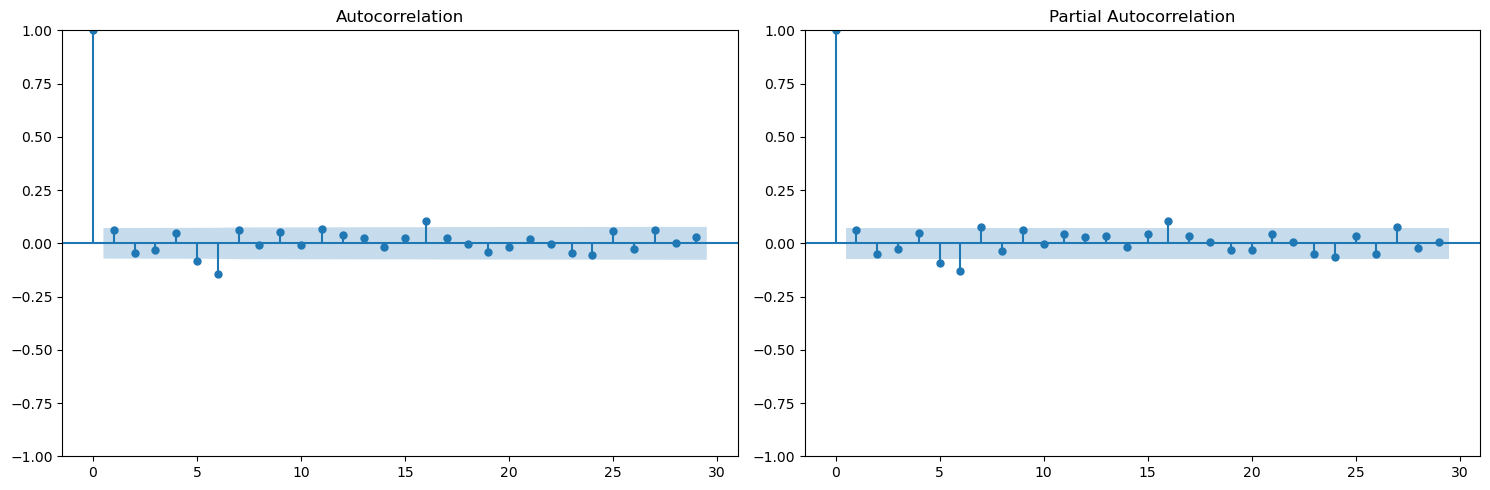

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data.brent.diff().dropna(), ax=ax[0])
plot_pacf(data.brent.diff().dropna(), ax=ax[1])
plt.tight_layout()

A moving average process is a linear combination of white noise processes so that $y_t$ depends on current and previous values of the disturbance term $u_t$ (Brooks, 2019). An integrated autoregressive process is one where the characteristic equation has a root in the unit circle. We build an ARIMA(4,1,1) model here, which is an ARMA model on the first-differenced crude price with 4 lags and 1 lag of the disturbance term. 

In [87]:
_ = data[['brent']].asfreq('D').copy()
arima = ARIMA(_, order=(4,1,1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  brent   No. Observations:                 1095
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -1710.272
Date:                Mon, 27 Nov 2023   AIC                           3432.543
Time:                        17:24:08   BIC                           3462.529
Sample:                    01-01-2020   HQIC                          3443.890
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4168      0.190      2.195      0.028       0.045       0.789
ar.L2         -0.1384      0.039     -3.520      0.000      -0.215      -0.061
ar.L3          0.2733      0.036      7.557      0.0

Following estimation of the ARIMA model (see appendix for full model table), the fitted values of the model can be plotted against the actual values of the crude oil price. As can be seen from the figure below, the ARIMA(4,1,1) model fits the actual time series excellently.

To find the 'unpredictable' part of this factor, the residuals are calculated. This reflects the surprise or unforecastable part of petrol pricing; this is risk that is priced by the market.

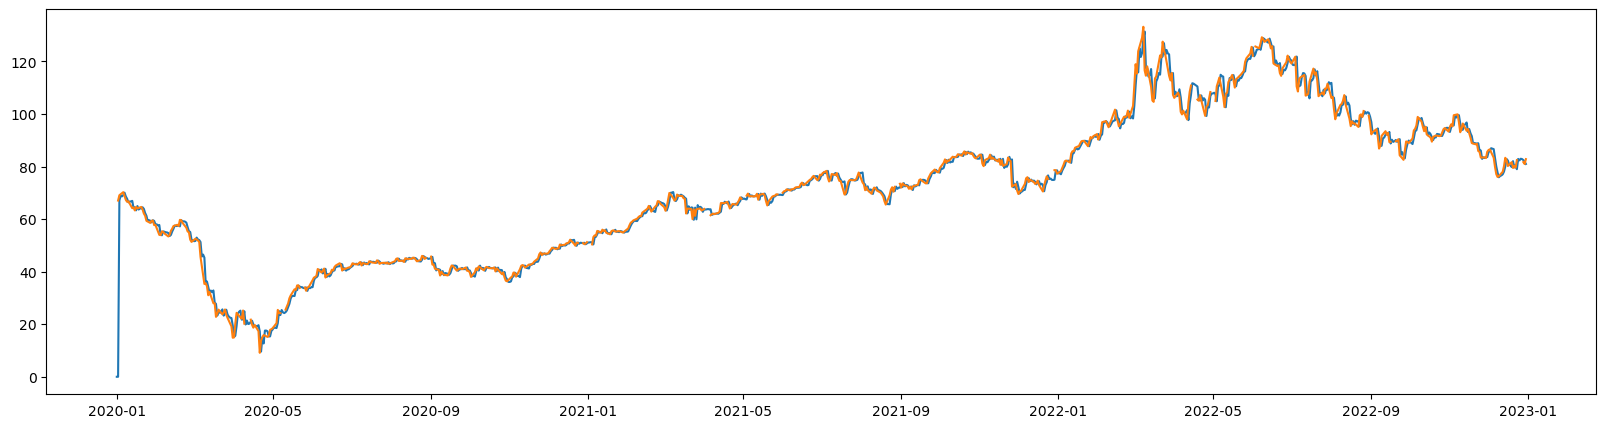

In [88]:
fig = plt.figure(figsize=(20, 5))
plt.plot(arima.fittedvalues)
plt.plot(data.brent)

In [89]:
factor_brent = pd.DataFrame(arima.resid.rename('brent').iloc[2:])

Having extracted the unpredictable part of the petrol pricing, we can see that it is a white noise process reflecting the unforecastability of the risk factors and the reasoning for them to be priced into the market.

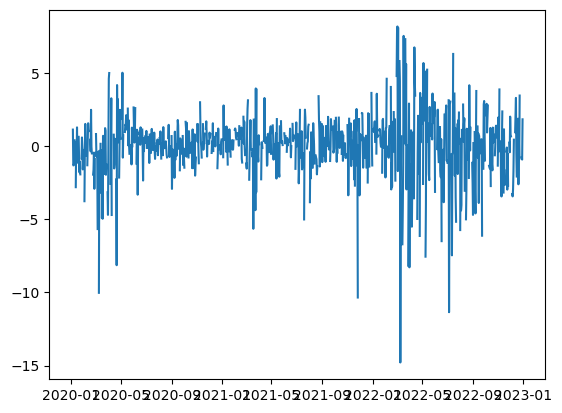

In [90]:
plt.plot(factor_brent)

## Tips BEI factor

As mentioned above, this factor captures the surprises in inflation. The process of extracting the unpredictable part is much the same as the petrol factor but involves a few more steps. First the difference between the Tbill yield and the inflation adjusted Tbill yield is calculated. This is called the break-even inflation rate, BEI. The process from here is the same as the petrol factor. The BEI is I(1) and the first-differenced BEI follows a moving average process. The ADF test on the first differences allows rejection of the null hypothesis that there is a unit root. The ACF and PACF functions are similar to those of the petrol factor with no coefficients significantly different from 0. 

In [91]:
tips = data[['ust10', 'usti10']].dropna().copy()

In [92]:
tips['bei'] = tips.ust10 - tips.usti10
tips.drop(['ust10', 'usti10'], axis=1, inplace=True)

In [93]:
adf_test_summary(tips.bei.diff().dropna())

-----------------------------------------------------------------------------
ADF Test BEI: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  #lags   #obs     1%     5%    10%
constant                 -24.789      0.0    0.0  749.0 -3.439 -2.865 -2.569
constant trend           -24.775      0.0    0.0  749.0 -3.971 -3.416 -3.131
constant ltend, qtrend   -24.848      0.0    0.0  749.0 -4.387 -3.840 -3.558
none                     -24.800      0.0    0.0  749.0 -2.569 -1.941 -1.616




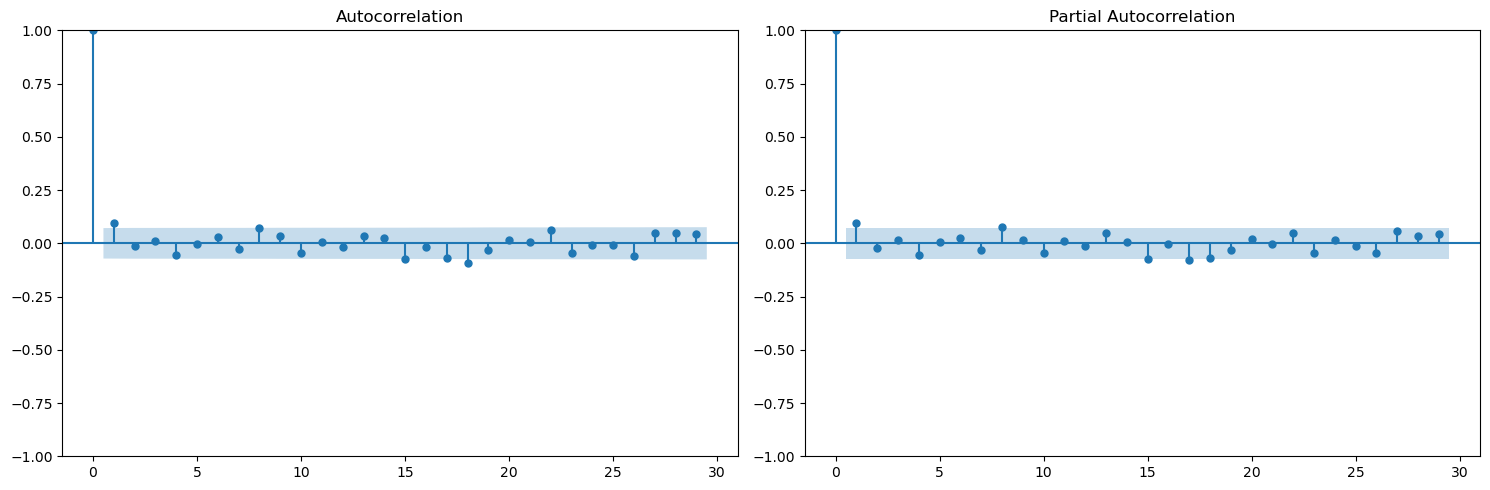

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(tips.bei.diff().dropna(), ax=ax[0])
plot_pacf(tips.bei.diff().dropna(), ax=ax[1])
plt.tight_layout()

Again, following the Box-Jenkins approach to specify the ARIMA model, we estimate an ARIMA(3,1,0).

In [95]:
tips = tips.asfreq('D')
arima = ARIMA(tips.bei, order=(3,1,0)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                    bei   No. Observations:                 1094
Model:                 ARIMA(3, 1, 0)   Log Likelihood                1277.594
Date:                Mon, 27 Nov 2023   AIC                          -2547.188
Time:                        17:24:11   BIC                          -2527.201
Sample:                    01-02-2020   HQIC                         -2539.624
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0474      0.026     -1.855      0.064      -0.098       0.003
ar.L2         -0.0485      0.036     -1.362      0.173      -0.118       0.021
ar.L3          0.0772      0.037      2.090      0.0

The fitted values and the actual values almost entirely overlay indicating a correctly specified model. Following from this, the unpredictable risk that is priced by the market needs to be extracted, so the residuals from the ARIMA model are saved as the unforecastable white noise risk factor.

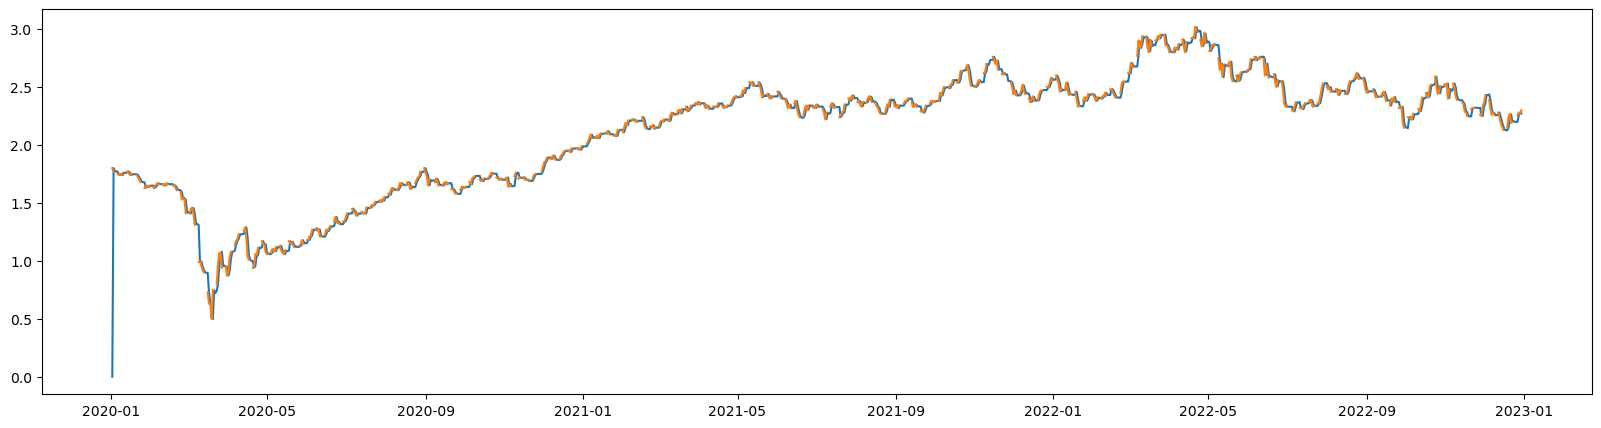

In [96]:
fig = plt.figure(figsize=(20, 5))
plt.plot(arima.fittedvalues)
plt.plot(tips.bei)

In [97]:
factor_bei = pd.DataFrame(arima.resid.rename('bei').iloc[1:])

Again, the residuals are a white noise process which is indicative of the unpredictability.

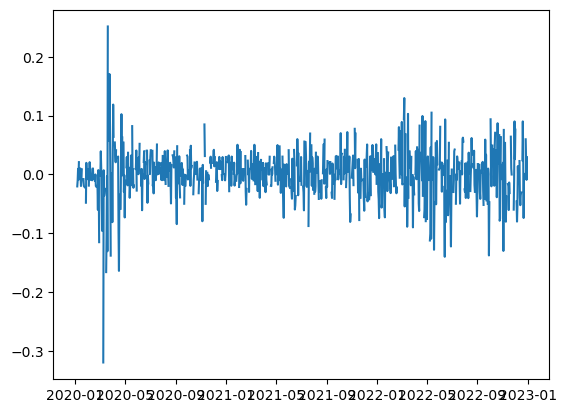

In [98]:
plt.plot(factor_bei)

## Interest Rate Expectation

The final factor estimated is the surprise in the prices of a risk free asset, effectively surprises in interest rates. We used the movements in the US 10 year treasury bond for this, the same time series used for the surprise inflation factor.

The time series is an I(1) process, with an ADF test on the first differences allowing rejection of the null hypothesis of a unit root.

In [99]:
adf_test_summary(data.ust10.diff().dropna())

-----------------------------------------------------------------------------
ADF Test UST10: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  #lags   #obs     1%     5%    10%
constant                 -20.299      0.0    1.0  717.0 -3.440 -2.866 -2.569
constant trend           -17.127      0.0    2.0  716.0 -3.971 -3.417 -3.131
constant ltend, qtrend   -17.228      0.0    2.0  716.0 -4.387 -3.841 -3.558
none                     -20.257      0.0    1.0  717.0 -2.569 -1.941 -1.616




The ACF and PACF tell the same story with no coefficients significantly different from 0.

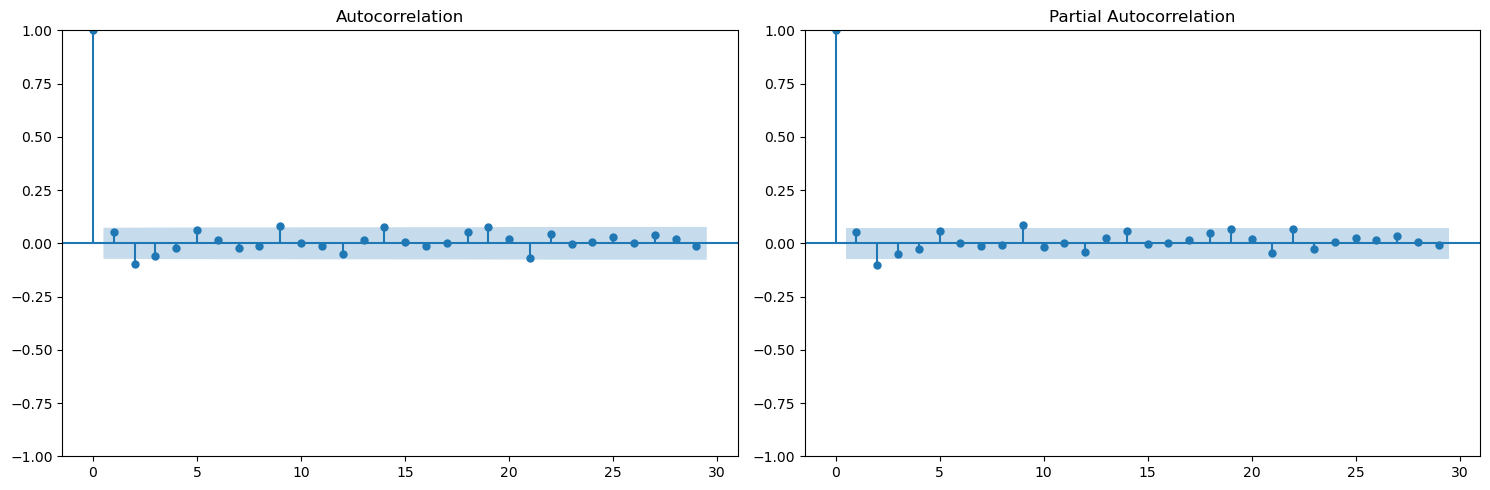

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data.ust10.diff().dropna(), ax=ax[0])
plot_pacf(data.ust10.diff().dropna(), ax=ax[1])
plt.tight_layout()

The best linear approximation relies on an ARIMA(2,1,1) model which is fitted with the residuals saved as the unpredictable time series.

In [101]:
_ = data[['ust10']].asfreq('D').copy()
arima = ARIMA(_, order=(2,1,1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  ust10   No. Observations:                 1095
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1018.647
Date:                Mon, 27 Nov 2023   AIC                          -2029.294
Time:                        17:24:16   BIC                          -2009.304
Sample:                    01-01-2020   HQIC                         -2021.730
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4406      0.201      2.189      0.029       0.046       0.835
ar.L2         -0.1165      0.037     -3.129      0.002      -0.190      -0.044
ma.L1         -0.4361      0.200     -2.183      0.0

Fitting the models again displays fitted values that are almost overlayed with the actual 10 year treasury bond yields suggesting a correctly specified model and the estimation of the best linear approximation.

Now, to extract the factor, the corresponding residual which is not correlated with the regressors is saved.

<Axes: xlabel='date'>

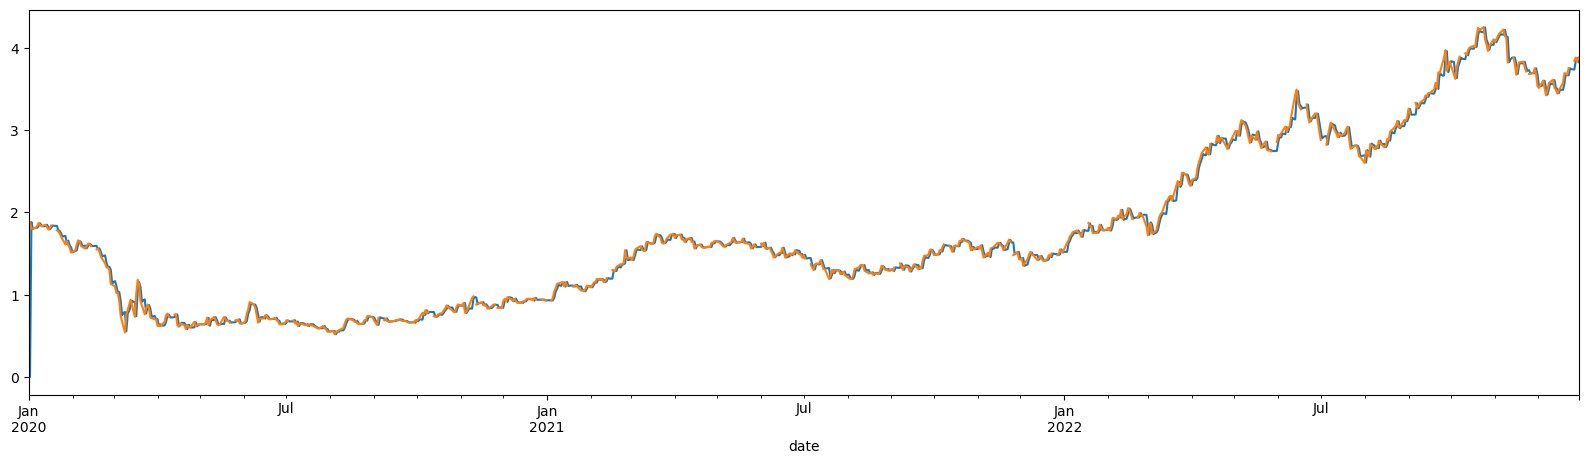

In [102]:
fig = plt.figure(figsize=(20,5))
arima.fittedvalues.plot()
data.ust10.plot()

In [103]:
factor_int = pd.DataFrame(arima.resid.iloc[2:].rename('int'))

The risk factor is a white noise process reflecting the unpredictability and deeming it worthy to be priced by the market.

<Axes: xlabel='date'>

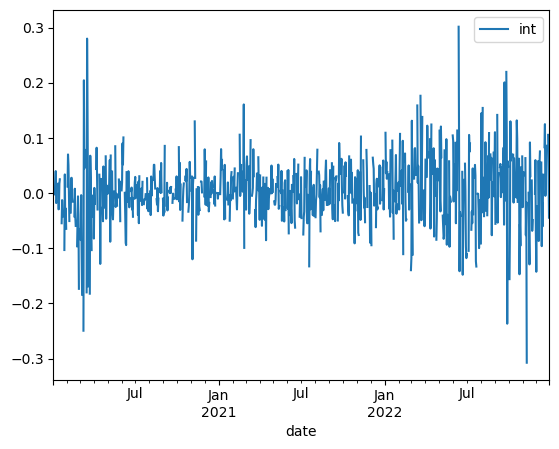

In [104]:
factor_int.plot()

# S&P 500 Stocks (Global Stock Index)

## Estimation of the beta coefficients

Now that the innovations of the different macroeconomic and financial series have been extracted, the beta coeffcients can be estimated.

To estimate the beta coefficients for the global index (the 30 stocks from the S&P500), we regress the series of the returns of the different assets ($R_{j,t}$) on the innovation series ($f_{k,t}$) and an intercept.

Hence, the beta coefficients are estimated, as well as the riskless rate of interest, $ρ$, by OLS. The estimates are $\hat{β_{jk}}$ and $\hat{ρ}$.

The expectations of the returns are indicated by the historical mean return giving
$$
\hat{E(R_j)} - \hat{ρ} = \frac{1}{T}Σ^T_{t=1}(r_{jt} - \hat{ρ})
$$
where $r_{jt}$ is the return of the asset $j$ at day $t$.

In [105]:
#Historical mean return

In [106]:
stocks = data[tickers].dropna().copy()

In [107]:
hist_mean_rets = stocks.mean().copy()
ρ_10y = np.log(data.ust10.dropna()).diff().dropna().mean()

hist_mean_rets = pd.DataFrame((hist_mean_rets - ρ_10y).rename('E_ret'))

In [108]:
factors = pd.concat([factor_brent, factor_int, factor_bei], axis=1).dropna()

In [109]:
betas = {}
errors = {}
intercepts = {}
for f in factors:
    _ = factors[[f]].join(stocks).dropna().copy()
    _['const'] = list([1] * len(_))
    
    ols = OLS(_[f], _.drop(f, axis=1)).fit()
    
    betas[f] = ols.params
    errors[f] = ols.resid
    intercepts[f] = ols.params['const']
    
betas = pd.DataFrame(betas)

As can be seen by the table in the appendix, each of the 30 stocks has a β for each factor. The sensitivity of the returns to the pretol factor appear to be highest. This is perhaps not because these firms' profits are extremely elastic to crude oil prices and so surprises in the crude oil price negatively affect the returns. Instead, the petrol factor can be interpreted as an indicator of the health of the economy, so the high sensitivity of the returns to this factor can indicate the pro-cyclical nature of some of these stocks, such as Google. We compare the sensitivity of the returns to the risk factors to the sector-specific index in the next part. 

The beta coefficients for the interest rate factor are generally much smaller than for the petrol factor, suggesting investors do not demand much higher returns for the risk associated with interest rate surprises when holding these stocks. The inflationary factor is smaller still. Many of these firms, such as GOOGL and AMZN are technology firms and have cash flows less sensitive to inflation than firms that are involved in construction or manufacturing for example. This may explain to an extent the lack of sensitivity of expected returns to inflationary surprises.

In [110]:
betas

,brent,int,bei
MMM,-7.184110,0.032418,-0.031088
AOS,-1.697174,0.054657,0.030267
ABT,-11.989577,0.379356,0.195580
ABBV,-0.147495,0.022441,0.089674
ACN,-11.245968,0.006100,0.286177
ADM,37.577152,0.387400,0.193286
ADBE,-3.987478,0.059330,-0.076384
ADP,11.867232,0.132379,0.167775
AES,5.100902,-0.284589,0.177329
AFL,-0.059490,1.023418,0.358499


In [112]:
transposed_betas = betas.transpose()

# Or you can use the .T attribute
#transposed_betas = betas.T

# Display the transposed DataFrame
transposed_betas

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,const
brent,-7.184110,-1.697174,-11.989577,-0.147495,-11.245968,37.577152,-3.987478,11.867232,5.100902,-0.059490,...,50.439642,-38.448942,17.069683,-0.767913,-12.293683,3.215074,15.287016,-17.619304,1.607883,-0.023439
int,0.032418,0.054657,0.379356,0.022441,0.006100,0.387400,0.059330,0.132379,-0.284589,1.023418,...,-0.314956,0.441678,0.377257,-0.001749,-0.125711,-0.029721,-0.350543,0.167490,-0.302575,0.004427
bei,-0.031088,0.030267,0.195580,0.089674,0.286177,0.193286,-0.076384,0.167775,0.177329,0.358499,...,0.240363,0.074559,0.382589,0.046850,-0.105696,0.086552,0.239242,0.100934,0.167263,-0.000482


In [41]:
idx = list(set(factors.index).intersection(stocks.index))

u_t = stocks.loc[idx].apply(lambda x: x - x.mean() - factors.loc[idx] @ betas.loc[x.name]).copy()
Σ_T = u_t.cov()
# Σ_T = np.array(np.sum([u_t.iloc[i] @ u_t.iloc[i].transpose() for i in range(0, len(u_t))]) * 1 / len(u_t)).reshape((1,1))

B = betas.drop('const').values

In [42]:
B

array([[-7.18411008e+00,  3.24176654e-02, -3.10877093e-02],
       [-1.69717380e+00,  5.46570622e-02,  3.02670533e-02],
       [-1.19895773e+01,  3.79355742e-01,  1.95579601e-01],
       [-1.47495093e-01,  2.24408104e-02,  8.96736901e-02],
       [-1.12459677e+01,  6.10013884e-03,  2.86177075e-01],
       [ 3.75771524e+01,  3.87399647e-01,  1.93285581e-01],
       [-3.98747753e+00,  5.93295879e-02, -7.63837045e-02],
       [ 1.18672319e+01,  1.32378920e-01,  1.67774865e-01],
       [ 5.10090164e+00, -2.84588601e-01,  1.77328745e-01],
       [-5.94899955e-02,  1.02341756e+00,  3.58498916e-01],
       [-1.40763214e+01, -3.22674886e-01, -4.38457064e-01],
       [ 1.05253139e+01, -2.13934197e-02,  1.78465729e-02],
       [-7.23435658e+00, -3.48120121e-01, -3.11744262e-01],
       [-6.08731879e+00, -3.90111020e-01,  5.92234428e-02],
       [ 2.54553219e+00, -4.91082867e-02, -1.30316171e-01],
       [ 1.25006152e+01,  1.77573258e-01,  1.85368517e-01],
       [ 4.78847022e+00, -5.49440294e-01

## Estimation of the Lambda Coefficients

Finally, we wish to calculate the market price of these risk factors, the $λ_k$. By regressing the historical means $\hat{E(R_j)} - \hat{ρ}$ on the beta coefficients we estimatd above we obtain the $λ_k$ parameters for our 30-stock portfolio. $\tilde{λ_1}$,...,$\tilde{λ_K}$ denote the estimates of the $λ_k$ parameters obtained by using the feasible generalised least squares:
$$
\tilde{λ} = (\hat{B}'\hat{Σ_T}^{-1}\hat{B})'\hat{B}'\hat{Σ_T}^{-1}(\hat{E(R)} - \hat{ρ}e)
$$


In [43]:
λ = (B.transpose() @ np.linalg.inv(Σ_T) @ B).transpose() @ B.transpose() @ np.linalg.inv(Σ_T) @ hist_mean_rets

λ.index = factors.columns
λ.columns = ['lambda']

In [44]:
factors

,brent,int,bei
date,,,
2020-01-03,2.030063,-0.080000,-0.030000
2020-01-06,1.133615,-0.002198,-0.020509
2020-01-07,-1.312243,0.019142,-0.010286
2020-01-08,-1.308471,0.039998,0.009472
2020-01-09,-1.154016,-0.017940,-0.009283
...,...,...,...
2022-12-22,-0.904957,0.006289,-0.074202
2022-12-23,3.461669,0.085980,0.000716
2022-12-28,-0.763592,0.044757,0.020976


As can be seen, the risk premium associated with the petrol factor is very small. The λ for the interest rate factor is large and postive. The factor is therefore seen by the market as a positive source of risk yielding a positive risk premium and investors require higher returns for holding assets that are subject to the risk of higher interest rates.

The lambda for the inflationary surprise factor is negative however. The negative risk premium implies that the market demands a lower expected return for holding assets that may be positively correlated with the inflationary risk factor. Investors may be willing to accept lower expected returns for assets that act as a hedge against surprise inflation. As mentioned above, the nature of many of the firms in our 30-stock portfolio makes them more immune to inflationary surprises because they are technology firms. Hence, the negative lambda could indicate our portfolio as a suitable hedge against inflationary surprises.

In [45]:
λ

,lambda
brent,2.181855
int,274.007650
bei,-527.016981


In [46]:
λ @ λ.transpose()

,brent,int,bei
brent,4.760491,597.844947,-1149.874605
int,597.844947,75080.192525,-144406.684692
bei,-1149.874605,-144406.684692,277746.898115


In [47]:
(hist_mean_rets.values - B @ λ).transpose() @ np.linalg.inv(Σ_T) @ hist_mean_rets.values

,0
lambda,-423.828827


In [48]:
np.linalg.inv(factors @ factors.transpose() / len(u_t))

array([[-1.31109319e+17,  4.53244304e+16,  2.30273655e+16, ...,
         2.13037603e+17,  9.49548554e+15,  3.45949368e+16],
       [-1.20858992e+17,  8.67843607e+16, -4.77642710e+15, ...,
         1.70256732e+17,  7.27105160e+16,  4.59557124e+15],
       [ 8.92435895e+16, -2.73156997e+16,  4.50505878e+16, ...,
        -2.38949787e+17, -8.94390274e+16,  5.17652027e+16],
       ...,
       [-5.54875224e+16, -6.77581458e+15,  3.11302075e+16, ...,
         7.54628085e+16, -2.35777054e+16,  6.13984739e+15],
       [ 1.25698785e+16,  9.08711256e+15, -7.98908706e+15, ...,
        -6.24953302e+15,  2.12005576e+16, -3.70263502e+15],
       [ 3.40011479e+15,  3.33639417e+14,  7.75743097e+15, ...,
         3.07997650e+15,  3.11052233e+15,  3.87822587e+15]])

In [49]:
import statsmodels.api as sm
y, X = pd.DataFrame(betas['int']).drop('const').values, pd.DataFrame(hist_mean_rets).values

glm = sm.GLM(y, X).fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:                            GLM   Df Residuals:                       29
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                         0.11329
Method:                          IRLS   Log-Likelihood:                -9.3921
Date:                Mon, 27 Nov 2023   Deviance:                       3.2853
Time:                        13:51:04   Pearson chi2:                     3.29
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04268
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            65.0450     53.902      1.207      0.228     -40.600     170.690
==============================================================================
"""

## Introduction of Fama-French Factors

Here we introduce the Eugene Fama's and Kenneth French's factors into the OLS regression of the 30 stocks from the S&P50 on our exogenous factors. Most of the beta coefficients are statistically different from zero. The coefficient for the $R_m - R_F$ factor is positive as one would expect. This requires that as the difference between the market rate of return and the risk free rate increases, in other words the market risk, investors require higher returns.

HML also has a positive and significant coefficient, although it is much smaller in magnitude than the market risk factor. HML reflects historical performance difference between portfolios of value stocks (large HML) and growth stocks (low HML). A higher HML indicates that the value stocks have typically outperformed growth stocks. The positive beta estimate for this factor indicates that, on average, investors are rewarded with higher returns when value stocks outperform growth stocks.

The factor for SMB is not significantly different from zero, suggesting that the risk factor is not priced into the market for our portfolio.

In [50]:
X = ff_factors.join(factors).join(stocks.sum(axis=1).rename('sp500')).dropna()

ols = OLS(X.sp500, X.drop('sp500', axis=1)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  sp500   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              1030.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):                   2.10e-290
Time:                        13:51:05   Log-Likelihood:                          466.32
No. Observations:                 502   AIC:                                     -918.6
Df Residuals:                     495   BIC:                                     -889.1
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.2953      0.004     72.705      0.000       0.287       0.303
SMB           -0.0078      0.006     -1.307      0.192      -0.019       0.004
HML            0.0323      0.004      7.389      0.000       0.024       0.041
RF            -0.3240      0.788     -0.411      0.681      -1.873       1.225
brent         -0.0071      0.002     -3.703      0.000      -0.011      -0.003
int           -0.3353      0.075     -4.487      0.000      -0.482      -0.188
bei            0.0897      0.123      0.731      0.465      -0.152       0.331
==============================================================================
Omnibus:                       10.610   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               15.980
Skew:                          -0.150   Prob(JB):                     0.000339
Kurtosis:                       3.821   Cond. No.                         455.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Sectoral Sub-Index

## Estimation of the beta coefficients

For the sectoral sub-index, we use the Dow Jones Utility Average (FRED, 2023). The DJUA tracks the performance of 15 large utility companies traded in the United States. The betas represent the sensitivity of an asset's returns to various systematic factors. Given the inelastic nature of utility companies, by virtue of their inelastic demand, we would expect the sentivities of the returns to be lower to the given risk factors compared to the S&P500. Indeed, many of the S&P500 companies are not directly affected by the petrol factor, for example, but the petrol factor captures the health of the economy in general and many of the 30 stocks we chose will have returns elastic to the health of the economy. Or rather, their returns are elastic to surprises in macroeconomic variables.

Utility companies on the other hand are far less affected by the business cycles. Indeed, if construction or production slows, the demand for energy declines and the stock prices may reflect this. But for the most part, utility companies are more resilient to economic downturns or surprises in macroeconomic variables. We follow the same process for the 30 individual stocks of the S&P500 but for the single DJUA index to estimate the beta coefficients and the lambdas.

In [51]:
reader = fred.FredReader(['DJUA'], start, end)
_data = reader.read().dropna()
_data.index.name = 'date'

In [52]:
_data

,DJUA
date,
2020-01-02,866.82
2020-01-03,867.44
2020-01-06,870.03
2020-01-07,868.60
2020-01-08,868.91
...,...
2022-12-23,975.58
2022-12-27,982.37
2022-12-28,973.40


In [53]:
data = np.log(_data['DJUA']).diff().dropna()

In [54]:
data

date
2020-01-03    0.000715
2020-01-06    0.002981
2020-01-07   -0.001645
2020-01-08    0.000357
2020-01-09    0.004295
                ...   
2022-12-23    0.009620
2022-12-27    0.006936
2022-12-28   -0.009173
2022-12-29    0.004541
2022-12-30   -0.010724
Name: DJUA, Length: 755, dtype: float64

In [55]:
data = data.to_frame(name='DJUA')

# Join the two DataFrames
data = data.join(ff_factors)

In [56]:
hist_mean_rets = data.mean().copy()
hist_mean_rets = pd.DataFrame((hist_mean_rets - ρ_10y).rename('E_ret'))

In [57]:
hist_mean_rets

,E_ret
DJUA,-0.000821
Mkt-RF,0.035617
SMB,0.005021
HML,0.019921
RF,0.001426


In [58]:
betas = {}
errors = {}
intercepts = {}
for f in factors:
    _ = factors[[f]].join(data).dropna().copy()
    _['const'] = list([1] * len(_))
    
    ols = OLS(_[f], _.drop(f, axis=1)).fit()
    
    betas[f] = ols.params
    errors[f] = ols.resid
    intercepts[f] = ols.params['const']
    
betas = pd.DataFrame(betas)

The betas are again estimated by OLS. Because of the sector of the utility companies, you would perhaps expect the β for the brent factor to be higher than for the 30 S&P500 stocks we used above. However, this is not the case. The β for brent is -14.623 which is much lower (in absolute value) than for many of the stocks in the previous section. A possible explanation for this is that the utility firms forming the Dow Jones Utility Average index are inelastic to the economic condition by virtue of the inelasticity of their supply. The coefficient for interest rate surprises is also negative, suggesting the DJUA returns increase when this risk factor decreases. Additionally, the coefficient for inflationary surprise is also negative implying that returns are negatively correlated with risk of inflationary surprise: they move in different directions.

In [59]:
betas

,brent,int,bei
DJUA,-14.622566,-0.886100,-0.308244
Mkt-RF,0.401089,0.012276,0.010581
SMB,-0.115563,-0.010333,-0.003114
HML,0.372485,0.016344,0.007568
RF,-51.868110,-0.114270,-0.544632
const,0.118587,0.002317,0.001413


In [60]:
idx = list(set(factors.index).intersection(data.index))

u_t = data.loc[idx].apply(lambda x: x - x.mean() - factors.loc[idx] @ betas.loc[x.name]).copy()
Σ_T = u_t.cov()
# Σ_T = np.array(np.sum([u_t.iloc[i] @ u_t.iloc[i].transpose() for i in range(0, len(u_t))]) * 1 / len(u_t)).reshape((1,1))

B = betas.drop('const').values

In [61]:
B

array([[-1.46225658e+01, -8.86100380e-01, -3.08243730e-01],
       [ 4.01088981e-01,  1.22757638e-02,  1.05814380e-02],
       [-1.15562934e-01, -1.03332782e-02, -3.11422891e-03],
       [ 3.72484713e-01,  1.63441278e-02,  7.56800519e-03],
       [-5.18681102e+01, -1.14269729e-01, -5.44631542e-01]])

## Estimation of Lambda Coefficients

In [62]:
λ = (B.transpose() @ np.linalg.inv(Σ_T) @ B).transpose() @ B.transpose() @ np.linalg.inv(Σ_T) @ hist_mean_rets

λ.index = factors.columns
λ.columns = ['lambda']

The most interesting changes between the S&P500 stocks and the Dow Jones Utility Average stocks is the sign of the lambdas. Now the lambda for the petrol factor is negative (but small) suggesting investors may be willing to accept lower returns on utility company stocks to hedge against oil price surprises. The lambda for the interest rate factor is very simlar in value to the S&P500 stocks, and it is likely that interest rate unpredictability, as a source of risk, impacts all stocks the same way regardless of sector. Finally, the lamda for inflationary surprises is now positive, suggesting investors demand higher expected returns for holding utility assets that are positively correlated with changes in inflation. They require compensation for holding utility company stocks that are subject to the risk of inflationary surprise. The magnitude of the lamda in absolute value is much lower than for the S&P500 stocks however.

In [63]:
λ

,lambda
brent,-0.493637
int,204.998812
bei,37.152267


In [64]:
λ @ λ.transpose()

,brent,int,bei
brent,0.243677,-101.194986,-18.339731
int,-101.194986,42024.512996,7616.170533
bei,-18.339731,7616.170533,1380.290917


In [65]:
(hist_mean_rets.values - B @ λ).transpose() @ np.linalg.inv(Σ_T) @ hist_mean_rets.values

,0
lambda,-141.987676


In [66]:
np.linalg.inv(factors @ factors.transpose() / len(u_t))

array([[ 1.14580306e+16,  7.43980867e+16,  6.53711958e+16, ...,
         8.25861852e+16,  1.26631577e+16,  5.55791932e+16],
       [ 2.40880657e+17,  1.09583653e+18, -2.65063895e+17, ...,
        -7.02182357e+17,  4.12377386e+16,  1.85597192e+17],
       [ 2.01586017e+17,  1.80573577e+18,  9.42520406e+16, ...,
        -1.84038176e+17, -2.65018783e+17,  4.36698835e+17],
       ...,
       [ 4.17578646e+15, -1.20879083e+17,  2.73342827e+16, ...,
         5.32805039e+16,  1.60543154e+16, -2.92038170e+16],
       [-6.55684574e+16, -4.34946435e+17, -9.89112223e+15, ...,
         1.36425679e+17,  1.10023931e+17, -1.19175938e+17],
       [-2.86928346e+15, -2.18221879e+16, -6.55755546e+15, ...,
        -2.20257105e+16,  1.30880406e+16, -1.87645490e+16]])

In [67]:
import statsmodels.api as sm
y, X = pd.DataFrame(betas['int']).drop('const').values, pd.DataFrame(hist_mean_rets).values

glm = sm.GLM(y, X).fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                    5
Model:                            GLM   Df Residuals:                        4
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                         0.19945
Method:                          IRLS   Log-Likelihood:                -2.5063
Date:                Mon, 27 Nov 2023   Deviance:                      0.79780
Time:                        13:51:15   Pearson chi2:                    0.798
No. Iterations:                     3   Pseudo R-squ. (CS):            -0.1845
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7531     10.853      0.069      0.945     -20.518      22.024
==============================================================================
"""

## Introduction of Fama-French factors

Here we introduce the Eugene Fama's and Kenneth French's factors into the OLS regression for the sectoral sub-index of American utility companies. All of the beta coefficients except the petrol factor and the inflationary surprise factor are significantly different from zero.


Most of the beta coefficients are statistically different from zero. The coefficient for the $R_m - R_F$ factor is positive as one would expect. This requires that as the difference between the market rate of return and the risk free rate increases, in other words the market risk, expected returns should increase in an almost 1:1 fashion.

Like with the S&P500 stocks, both HML and $R_m - R_F$ are positive, indicating a reward for increases in these risk factors. Additionally, the factor for SMB is statistically significant. SMB measures the outperformance of small-cap companies compared to big-cap firms. Historically, small-cap companies see higher returns than big-cap companies, hence the positive beta coefficient and the almost 1:1 sensitivity of the DJUA index's return to this SMB risk factor.

Comparing to the S&P500 stocks, we see an increase in the beta for the market risk factor, a negative SMB and a decrease in HML. Overall, the coefficients tend to be larger for the utility companies, especially for the Fama-French factors, but lower for the exogenous factors that we constructed such as the petrol factor, the interest rate factor and the surprise inflation factor. This suggests that the returns of the DJUA are more sensitive to market fundamentals and less sensitive to surprises in macroeconomic variables.

In [113]:
X = ff_factors.join(factors).join(data.sum(axis=1).rename('DJUA')).dropna()

In [74]:
ols = OLS(X.DJUA, X.drop('DJUA', axis=1)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   DJUA   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.765e+06
Date:                Mon, 27 Nov 2023   Prob (F-statistic):                        0.00
Time:                        14:26:55   Log-Likelihood:                          2268.0
No. Observations:                 735   AIC:                                     -4522.
Df Residuals:                     728   BIC:                                     -4490.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.0081      0.000   3731.506      0.000       1.008       1.009
SMB            0.9953      0.001   1931.300      0.000       0.994       0.996
HML            1.0028      0.000   3053.280      0.000       1.002       1.003
RF             1.0058      0.085     11.824      0.000       0.839       1.173
brent         -0.0003      0.000     -1.489      0.137      -0.001    9.43e-05
int           -0.0324      0.007     -4.361      0.000      -0.047      -0.018
bei           -0.0085      0.011     -0.766      0.444      -0.030       0.013
==============================================================================
Omnibus:                      136.447   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1740.471
Skew:                           0.400   Prob(JB):                         0.00
Kurtosis:                      10.496   Cond. No.                         483.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion

To conclude, we have estimated a factorial model including exogenous and endogenous factors based on Ross' (1976) arbitrage pricing theory. We have used data from both the S&P500 stocks and a sectoral sub-index, the Dow Jones Utility Average index, to estimate the multibeta relationship and the corresponding market price of the different risk factors, introducing. We have elaborated on the differences observed in both the signs and the magnitudes of the lamdas and betas for the different sectors and introduced the Fama-French factors from Kenneth French's database.

# References

Brooks, C., 2019. Introductory econometrics for finance. Cambridge university press.

Campbell, J.Y., Lo, A.W., MacKinlay, A.C. and Whitelaw, R.F., 1998. The econometrics of financial markets. Macroeconomic Dynamics.

French, K.R. (2023) Kenneth R. French - data library. Available at: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html (Accessed: 25 November 2023). 

FRED (2023) Market yield on U.S. Treasury securities at 10-year constant maturity, quoted on an investment basis, FRED. Available at: https://fred.stlouisfed.org/series/DGS10 (Accessed: 25 November 2023). 

FRED (2023a) Crude oil prices: Brent - Europe, FRED. Available at: https://fred.stlouisfed.org/series/DCOILBRENTEU (Accessed: 25 November 2023). 

FRED (2023c) Market yield on U.S. Treasury securities at 10-year constant maturity, quoted on an investment basis, inflation-indexed, FRED. Available at: https://fred.stlouisfed.org/series/DFII10 (Accessed: 25 November 2023). 

FRED (2023d) Dow Jones utility average, FRED. Available at: https://fred.stlouisfed.org/series/DJUA (Accessed: 26 November 2023). 

Stephen, R., 1976. The arbitrage theory of capital asset pricing. Journal of Economic Theory, 13(3), pp.341-360.

Yahoo Finance (2023) Yahoo Finance - Stock Market Live, quotes, Business &amp; Finance News, Yahoo! Finance. Available at: https://finance.yahoo.com/ (Accessed: 25 November 2023). 

# Appendix of Codes and Supplementary Material